# マルチタスクMDPにおける文脈の推定

参考：
* [RL for Latent MDPs: Regret Guarantees and a Lower Bound](https://arxiv.org/abs/2102.04939)
* [Understanding Domain Randomization for Sim-to-real Transfer](https://arxiv.org/abs/2110.03239)

表記：
* $\mathcal{M}$をMDPの集合とします．
* $M=|\mathcal{M}|, S=|\mathcal{S}|$ and $A=|\mathcal{A}|$とします．
* 各要素$\mathcal{M}_m \in \mathcal{M}$は$\left(\mathcal{S}, \mathcal{A}, P_m, R, \mu\right)$のタプルとして，ここで$P_m$は遷移確率，$R$は報酬，$\mu$は初期分布です．今回は簡単のために遷移だけ異なる場合を考えます．

マルチタスクMDPでは一般に２つのフェーズがあります．
1. 事前学習フェーズ：事前に何らかの知識をMDPの集合$\mathcal{M}$から抽出する
2. 適応フェーズ：何らかのタスク（MDP）$\mathcal{M}_m$を解くことが求められるが，これが何のタスクかはわからない．

マルチタスクMDPに対するアプローチはいろいろありますが，今回は特に適応フェーズにて「何のタスクを解いているのか？」を推定する手法について考えてみます．
これは[RL_multi_task_contextual_MDP.ipynb](RL_multi_task_contextual_MDP.ipynb)や[RL_multi_task_latent_MDP.ipynb](RL_multi_task_latent_MDP.ipynb)などで登場します．


## 文脈の推定

簡単のために，シンプルなケースを考えてみましょう．
* 各MDPの遷移$P_m$は既知とします．

また，次の仮定を導入します．

---

**$\delta$-separated MDP**

任意の$m_1\neq m_2$な$m_1, m_2 \in [M]$および$(s, a) \in \mathcal{S}\times \mathcal{A}$について，

$$\left\|\left(\mathbb{P}_{m_1}-\mathbb{P}_{m_2}\right)(o \mid s, a)\right\|_1 \geq \delta$$
とします．

---

このときに，何らかの軌跡$\tau=\left(s_1, a_1, \ldots, s_H, a_H\right)$が与えられて，これがどのMDPから来たのかを推定しましょう．
以下，任意の$\pi$について成立する理論を与えるので，$\pi$についての表記は省略します．

表記：
* 真のMDPを$m^*$とします．
* 軌跡$\tau$を$m$個目のMDPで方策$\pi$によって得られる確率を$\mathbb{P}_{\tau \sim M_m, \pi}(\tau)=\mathbb{P}_{m}(\tau)$とします．

このとき，次が成立します．

---

$\tau$を$\mathcal{M}_{m^*}$から方策$\pi$によってサンプルした軌跡とします．
$\delta$-separated MDPの仮定が成立しているとします．
任意の$m \neq m^*$と任意の方策$\pi$について，

$$
\ln \left(\frac{\mathbb{P}_{m^*}(\tau)}{\mathbb{P}_{m}(\tau)}\right)>c \ln \left(M / \epsilon_p\right), \quad \forall m \neq m^*
$$

が確率$1 - (\epsilon_p / M)^4$以上で成立します．ここで$\epsilon_p > 0$，$c > 0$は定数です．

**証明**

まず，任意の履歴依存の方策$\pi$に対して，

$$\ln \left(\frac{\mathbb{P}_{m^*}(\tau)}{\mathbb{P}_m(\tau)}\right)=\sum_{t=1}^H \ln \left(\frac{\mathbb{P}_{m^*}\left(s_{t+1} \mid s_t, a_t\right)}{\mathbb{P}_m\left(s_{t+1} \mid s_t, a_t\right)}\right)$$

が成り立ちます（異なるのは遷移だけなので）．

ここで，$\ln \left(\frac{\mathbb{P}_{m^*}(\tau)}{\mathbb{P}_m(\tau)}\right)$は分母が０になり得るので有界ではありません．
そこで，$\alpha \ln (1 / \alpha)<\delta^2 /(200 S)$を満たすような十分小さい$\alpha$を使って，

$$\hat{\mathbb{P}}_m(s' \mid s, a)=\alpha+(1-2 \alpha S) \mathbb{P}_m(s' \mid s, a)$$
となるような$\hat{\mathbb{P}}_m$を定義します．
このとき，

$$
\ln \left(\frac{\mathbb{P}_{m^*}(\tau)}{\mathbb{P}_m(\tau)}\right)=\ln \left(\frac{\mathbb{P}_{m^*}(\tau)}{\hat{\mathbb{P}}_m(\tau)}\right)+\ln \left(\frac{\hat{\mathbb{P}}_m(\tau)}{\mathbb{P}_m(\tau)}\right)
$$

です．
最初の項をバウンドします．
まず，最初の項の期待値は次でバウンドされます．

$$
\begin{aligned}
\mathbb{E}\left[\sum_{t=1}^H \ln \left(\frac{\mathbb{P}_{m^*}\left(s_{t+1} \mid s_t, a_t\right)}{\hat{\mathbb{P}}_m\left(s_{t+1} \mid s_t, a_t\right)}\right)\right] & =\mathbb{E}\left[\sum_{t=1}^H \mathbb{E}\left[\ln \left(\frac{\mathbb{P}_{m^*}\left(s_{t+1} \mid s_t, a_t\right)}{\hat{\mathbb{P}}_m\left(s_{t+1} \mid s_t, a_t\right)}\right) \mid s_1, a_1, s_2, \ldots, s_t, a_t\right]\right] \\
& =\mathbb{E}\left[\sum_{t=1}^H \sum_{s_{t+1}} \mathbb{P}_{m^*}\left(s_{t+1} \mid s_t, a_t\right) \ln \left(\frac{\mathbb{P}_{m^*}\left(s_{t+1} \mid s_t, a_t\right)}{\hat{\mathbb{P}}_m\left(s_{t+1} \mid s_t, a_t\right)}\right)\right] \\
& =\mathbb{E}\left[\sum_{t=1}^H D_{K L}\left(\mathbb{P}_{m^*}\left(s_{t+1} \mid s_t, a_t\right), \hat{\mathbb{P}}_m\left(s_{t+1} \mid s_t, a_t\right)\right)\right] \geq H \delta^2,
\end{aligned}
$$

一行目はTower rule，二行目は$s_t, a_t$で条件づけされてるため，そして最後の不等式はPinskerの不等式と$\delta$-separated assumptionのせいです．

期待値がバウンドできたので，サンプルされた$\tau$についてのバウンドを考えましょう．そのために，次の補題を使います．

---

$X$を有限なsupport $\mathcal{X}$上の任意の離散確率変数とする．
このとき， $\ln (1 / \mathbb{P}(X))$ は 
[Orclizノルム](https://en.wikipedia.org/wiki/Orlicz_space)が
$\|\ln (1 / \mathbb{P}(X))\|_{\psi_1}=1 / e$
なsub-exponential 確率変数である．

**証明**

Orclizノルムの定義から，

$$
\begin{aligned}
\|\ln (1 / \mathbb{P}(X))\|_{\psi_1} & =\sup _{q \geq 1} q^{-1} \mathbb{E}_X\left[\ln ^q(1 / \mathbb{P}(X))\right]^{1 / q} \\
& =\sup _{q \geq 1} q^{-1}\left(\sum_{X \in \mathcal{X}} \mathbb{P}(X) \ln ^q(1 / \mathbb{P}(X))\right)^{1 / q}
\end{aligned}
$$

です．ここで，$p \ln ^q(1 / p)$は$p=e^{-q}$のときに最大値$(q/e)^q$を取ります．よって，

$$
\begin{aligned}
\|\ln (1 / \mathbb{P}(X))\|_{\psi_1} & =\sup _{q \geq 1} q^{-1}\left(\sum_{X \in \mathcal{X}} \mathbb{P}(X) \ln ^q(1 / \mathbb{P}(X))\right)^{1 / q} \\
& \leq \sup _{q \geq 1} q^{-1}(q / e)=1 / e .
\end{aligned}
$$

が成り立ちます．

---

ここで，$\ln \left(\mathbb{P}_{m^*}(\tau)\right)=\sum_{t=1}^H \ln \left(\mathbb{P}_{m^*}\left(s_{t+1} \mid s_t, a_t\right)\right)$なので，これは$H$個のsub-exponentialなマルチンゲールの和になります．
上の補題を使って，sub-exponential martingaleの集中不等式を使うと，

$$
\mathbb{P}\left(\ln \left(\mathbb{P}_{m^*}(\tau)\right) \leq \mathbb{E}\left[\ln \left(\mathbb{P}_{m^*}(\tau)\right)\right]-H \epsilon_1\right) \leq \exp \left(-c \cdot \min \left(\epsilon_1, \epsilon_1^2\right) H\right)
$$

がわかります（ここで$c$と$\varepsilon_1$は定数です）．
Azuma-Hoeffdingより，
$$
\mathbb{P}\left(\ln \left(\hat{\mathbb{P}}_m(\tau)\right) \geq \mathbb{E}\left[\ln \left(\hat{\mathbb{P}}_m(\tau)\right)\right]+H \epsilon_2\right) \leq \exp \left(-\frac{H \epsilon_2^2}{2 \log ^2(1 / \alpha)}\right)
$$
もわかります（ここで$\varepsilon_2$は定数です）．

$\epsilon=\epsilon_1+\epsilon_2=c_2 \cdot \log (1 / \alpha) \sqrt{2 \log \left(M / \epsilon_p\right) / H}$
としましょう．もしホライゾンが$H \geq C_0 \delta^{-4} \log ^2(1 / \alpha) \log \left(M / \epsilon_p\right)$であれば，

$$\ln \left(\frac{\mathbb{P}_{m^*}(\tau)}{\hat{\mathbb{P}}_m(\tau)}\right) \geq H \delta^2-H \epsilon \geq H \delta^2 / 2$$

が確率$1-\left(\epsilon_p / M\right)^5$以上で成立します．

最後に，２つ目の項をバウンドします．$\left\|\mathbb{P}_m-\hat{\mathbb{P}}_m(s' \mid s, a)\right\|_1 \leq 4 S \alpha$であり，$2\alpha S$が十分小さいことに注意すれば，

$$\ln \left(\frac{\hat{\mathbb{P}}_m(s' \mid s, a)}{\mathbb{P}_m(s' \mid s, a)}\right) \geq-4 \alpha S$$
です．よって，

$$
\ln \left(\hat{\mathbb{P}}_m(\tau) / \mathbb{P}_m(\tau)\right) \geq-4 \alpha S H \geq - H \delta^2 / 4
$$

になります($\alpha$は十分小さいので)．

以上より，

$$
\ln \left(\mathbb{P}_{m^*}(\tau) / \mathbb{P}_m(\tau)\right) \geq H \delta^2 / 4 \geq 4 \log \left(M / \epsilon_p\right)
$$

が成り立ちます．

---

以上をまとめると，
$\tau$が$M_{m^*}$からサンプルされるとき，任意の方策$\pi$について，

$$
\mathbb{P}_{\tau \sim \mathcal{M}_{m^*}, \pi}\left(\frac{\mathbb{P}_{\tau \sim \mathcal{M}_m, \pi}(\tau)}{\mathbb{P}_{\tau \sim \mathcal{M}_{m^*}, \pi}(\tau)}>\left(\epsilon_p / M\right)^{c_1}\right)<\left(\epsilon_p / M\right)^{c_2} \quad \forall m \neq m^*
$$

が失敗確率$\epsilon_p$と定数$c_1, c_2 \geq 4$について成立します．

---



次の手順で文脈のbeliefを計算します．beliefが大きい$m$ほど，$\tau$は$m$から出てきた可能性が高いです．

1. 入力：$\tau=\left(s_1, a_1, r_1, \ldots, s_H, a_H, r_H\right)$
2. $\hat{p}_m(\tau)=\Pi_{t=1}^H\left(\alpha+(1-2 \alpha S) \hat{\mathbb{P}}_m\left(s_{t+1} \mid s_t, a_t\right)\right)$
3. $\hat{b}(m)=\frac{\hat{p}_m(\tau)}{\sum_{m=1}^M \hat{p}_m(\tau)}$

このとき，次が成立します．

---

定数$C$と$\beta$について，
$H>C \cdot \delta^{-4} \log ^2(1 / \alpha) \log (\beta)$
であれば，
$\hat{b}\left(m^*\right) \geq 1-(N / \eta)^{-4}$
が確率$1-(N / \eta)^{-4}$で成立する．

**証明**

こっから先は簡単なので省略します．

---

In [1]:
import numpy as np
from typing import NamedTuple, Optional


S = 10  # 状態集合のサイズ
A = 3  # 行動集合のサイズ
S_set = np.arange(S)  # 状態集合
A_set = np.arange(A)  # 行動集合


# 初期状態分布を適当に作ります
mu = np.random.uniform(size=(S,))
mu = mu / np.sum(mu)
np.testing.assert_allclose(mu.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


class MDP(NamedTuple):
    S_set: np.array  # 状態集合
    A_set: np.array  # 行動集合
    H: int  # ホライゾン
    P: np.array  # 遷移確率行列
    mu: np.array  # 初期分布
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


def make_MDP(H: int):
    # 遷移確率行列を適当に作ります
    P = np.random.uniform(size=(H, S*A, S))
    P = P / np.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
    P = P.reshape(H, S, A, S)
    np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します

    # 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでMDPのクラスを作ります
    mdp = MDP(S_set, A_set, H, P, mu)
    return mdp


In [3]:
def make_MDPs(num_MDPs: int, H: int):
    MDPs = [make_MDP(H) for _ in range(num_MDPs)]
    return MDPs


def collect_trajectory(MDPs):
    true_MDP = MDPs[0]
    H = true_MDP.H

    # 先頭を真のMDPとします．
    random_policy = np.random.uniform(size=(H, S, A))
    random_policy = random_policy / random_policy.sum(axis=-1, keepdims=True)

    # 真のMDPの軌跡を収集します
    s = np.random.choice(true_MDP.S_set, p=true_MDP.mu)
    traj = []
    for h in range(H):
        policy_h = random_policy[h]
        a_h = np.random.choice(true_MDP.A_set, p=policy_h[s])
        trans = true_MDP.P[h, s, a_h]
        ns = np.random.choice(true_MDP.S_set, p=trans)

        traj.append((h, s, a_h, ns))
        s = ns

    return traj

In [9]:
alpha = 1e-7

def inference_context(traj, MDPs):
    p_traj_list = []
    for mdp in MDPs:
        p_traj = 1.0
        Pm = mdp.P
        for h, s, a, ns in traj:
            p = Pm[h, s, a, ns]
            p_traj = p_traj * (alpha + (1 - 2*alpha*S) * p)
        p_traj_list.append(p_traj)

    p_traj_list = np.array(p_traj_list) / sum(p_traj_list)
    return np.argmax(p_traj_list) == 0  # 先頭が真のMDPです

Text(0, 0.5, 'Inference success rate')

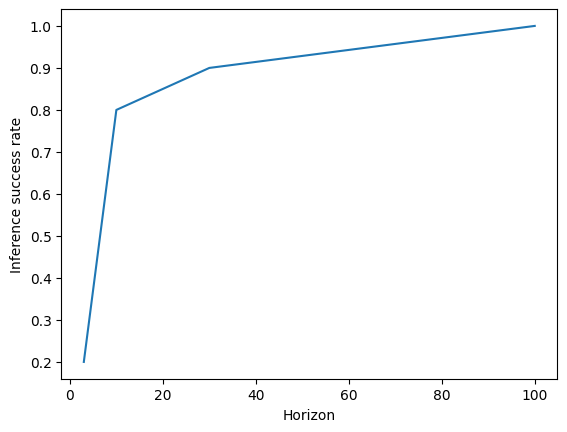

In [10]:
import matplotlib.pyplot as plt

num_MDPs = 8
horizons = [3, 10, 30, 100]
success_rates = []

for H in horizons:
    success_rate = 0

    for seed in range(10):
        MDPs = make_MDPs(num_MDPs, H)
        traj = collect_trajectory(MDPs)
        success_rate += inference_context(traj, MDPs)
    
    success_rates.append(success_rate / 10)

plt.plot(horizons, success_rates)
plt.xlabel("Horizon")
plt.ylabel("Inference success rate")

ホライゾンが長くなるほど文脈の推定の成功率が高くなっていますね．
これは理論と同じです．